In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install pgmpy

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

import commonfunc

In [5]:
data_set_path = "./sampled_data_csv_100/"

# icustays

## Read samples

In [6]:
icustays_df = commonfunc.read_csv_no_rowid(data_set_path+"icustays.csv")

In [7]:
icustays_df['icustay_id'].value_counts()

209341    1
263100    1
227339    1
210530    1
215795    1
         ..
275689    1
275869    1
211702    1
234598    1
292639    1
Name: icustay_id, Length: 138, dtype: int64

## Data preproces

In [8]:
# Drop useless colums
icustays_df.drop(['los'], axis=1, inplace=True)

### Process null values

In [10]:
# Check null value in table
commonfunc.nan_count(icustays_df)

Total columns: 10
Total rows: 138
--------------
subject_id        0
hadm_id           0
icustay_id        0
dbsource          0
first_careunit    0
last_careunit     0
first_wardid      0
last_wardid       0
intime            0
outtime           0
dtype: int64


### Set the column types

In [11]:
icustays_df.dtypes

subject_id         int64
hadm_id            int64
icustay_id         int64
dbsource          object
first_careunit    object
last_careunit     object
first_wardid       int64
last_wardid        int64
intime            object
outtime           object
dtype: object

In [12]:
# Transfer some date type
icustays_df['intime'] = pd.to_datetime(icustays_df['intime'])
icustays_df['outtime'] = pd.to_datetime(icustays_df['outtime'])

In [13]:
icustays_df.dtypes

subject_id                 int64
hadm_id                    int64
icustay_id                 int64
dbsource                  object
first_careunit            object
last_careunit             object
first_wardid               int64
last_wardid                int64
intime            datetime64[ns]
outtime           datetime64[ns]
dtype: object

### Process time value

In [15]:
admissions_df = commonfunc.read_csv_no_rowid(data_set_path+"admissions.csv")

In [16]:
admittime_df = admissions_df.loc[:, ['hadm_id', 'admittime']]
admittime_df['admittime'] = pd.to_datetime(admittime_df['admittime'])

In [17]:
icustays_mid_df = pd.merge(left=icustays_df, right=admittime_df, how='left', on=['hadm_id'])

In [19]:
icustays_mid_df['outtime'] = icustays_mid_df.apply(commonfunc.time_process, args=('intime', 'outtime'), axis=1)
icustays_mid_df['intime'] = icustays_mid_df.apply(commonfunc.time_process, args=('admittime', 'intime'), axis=1)

In [20]:
icustays_df = icustays_mid_df.drop(['subject_id', 'hadm_id', 'admittime'], axis=1)

In [21]:
icustays_df.columns

Index(['icustay_id', 'dbsource', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime'],
      dtype='object')

---

##  Build Network

In [22]:
from sdv.tabular import CTGAN


In [23]:
icustays_df.columns

Index(['icustay_id', 'dbsource', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime'],
      dtype='object')

### Set constraint

In [24]:
# def time_is_valid(column_names, data):
#     intime_outtime = ((data['outtime'] - data['intime']).apply(lambda x: 0 <= x.days  <= 365))
    
#     return intime_outtime

# def time_trasform(column_names, data):
#     # print(data.loc[:, ['dod', 'dod_hosp', 'dod_ssn']])
#     return data

# def time_reverse_transform(column_names, transformed_data):
#     transformed_data['intime'] = pd.to_datetime(transformed_data['intime'])
#     transformed_data['outtime'] = pd.to_datetime(transformed_data['outtime'])

#     return transformed_data

In [25]:
# TimeProcess = create_custom_constraint(
#     is_valid_fn=time_is_valid,
#     transform_fn=time_trasform,
#     reverse_transform_fn=time_reverse_transform
# )

# time_constraint = TimeProcess(
#     column_names=['intime', 'outtime']
# )

In [26]:
from sdv.constraints import Unique

unique_icustay_id_constraint = Unique(
    column_names=['icustay_id']
)

In [27]:
constraints = [unique_icustay_id_constraint]

### Build and train model

In [29]:
train_data = icustays_df
best_model = commonfunc.build_model(constraints=constraints, train_data=train_data)

Strat training ...
Tabular Preset


Sampling rows: 100%|██████████| 138/138 [00:00<00:00, 1663.96it/s]

Gaussian Copula



Sampling rows: 100%|██████████| 138/138 [00:00<00:00, 2793.52it/s]


CTGAN


Sampling rows: 100%|██████████| 138/138 [00:00<00:00, 761.99it/s] 


CopulaGAN


Sampling rows: 100%|██████████| 138/138 [00:00<00:00, 1028.48it/s]


TVAE


Sampling rows: 100%|██████████| 138/138 [00:00<00:00, 1578.20it/s]


Training finished!
Strat evaluating ...
Evaluating finished!
Gaussian Copula


Sampling rows: 100%|██████████| 138/138 [00:00<00:00, 4934.52it/s]


The best model is: tvae
The ContinuousKL_score is: 0.1896312374139224
The DiscreteKL_score is: 0.45051424501343657
The total score is: 0.44160866531316284


In [31]:
model_save_path = "C:\\Users\\shrus\\Documents\\Synthetic-data-generation\\models_100\\" + "icustays_model.pkl"
commonfunc.save_model(best_model, model_save_path)

---

## Evaluate data

### Generate synthetic data

In [33]:
# Load model
date_load_path = "C:\\Users\\shrus\\Documents\\Synthetic-data-generation\\models_100\\" + "icustays_model.pkl"
model = commonfunc.load_model(date_load_path)

In [34]:
sample = model.sample(len(icustays_df))

Sampling rows: 100%|██████████| 138/138 [00:00<00:00, 4449.20it/s]


In [35]:
sample.head()

,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime
0,242712,carevue,NICU,CSRU,52,50,249887.0,1592444.0
1,289335,carevue,SICU,MICU,20,14,435315.0,692850.0
2,227246,metavision,MICU,MICU,48,44,644332.0,935970.0
3,232898,carevue,NICU,NICU,47,43,313673.0,909530.0
4,289215,carevue,TSICU,CCU,13,8,351935.0,1151175.0


### Evaluation 

In [36]:
from sdv.evaluation import evaluate

In [37]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.42366668579746175

In [38]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.17920444691421947

In [39]:
sample['dbsource'].value_counts()

carevue       87
metavision    51
Name: dbsource, dtype: int64

In [40]:
evaluate(sample, train_data)

0.42801718545608164

array([<Axes: ylabel='dbsource'>], dtype=object)

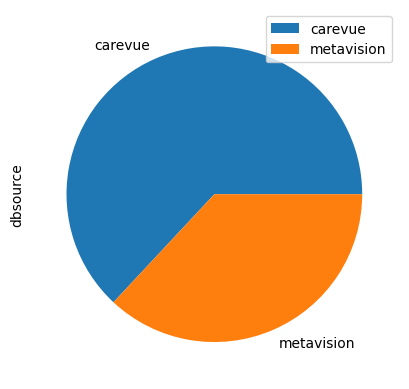

In [41]:
sample['dbsource'].value_counts().to_frame().plot.pie(subplots=True)

In [42]:
train_data['dbsource'].value_counts()

carevue       70
metavision    68
Name: dbsource, dtype: int64

array([<Axes: ylabel='dbsource'>], dtype=object)

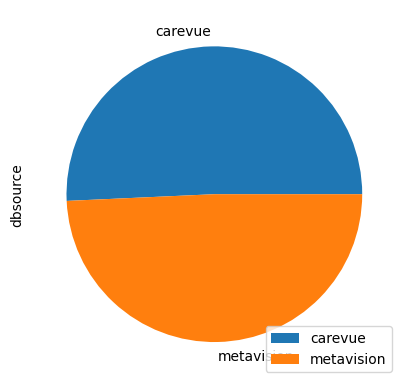

In [43]:
train_data['dbsource'].value_counts().to_frame().plot.pie(subplots=True)

<Axes: >

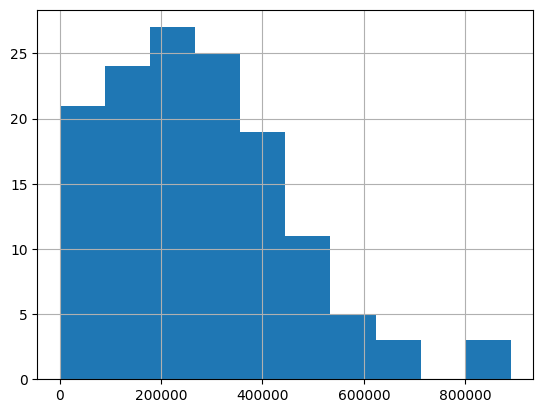

In [44]:
sample['intime'].hist()

<Axes: >

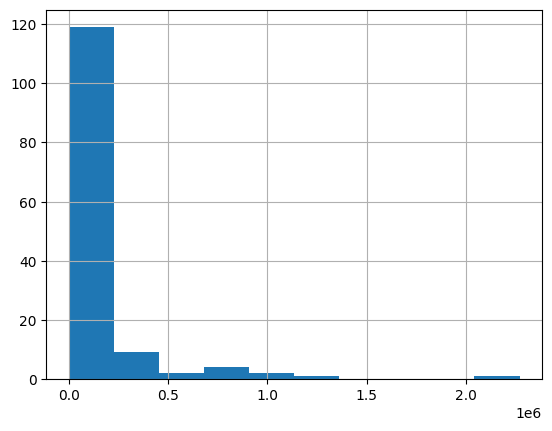

In [45]:
train_data['intime'].hist()

array([[<Axes: title={'center': 'icustay_id'}>,
        <Axes: title={'center': 'first_wardid'}>],
       [<Axes: title={'center': 'last_wardid'}>,
        <Axes: title={'center': 'intime'}>],
       [<Axes: title={'center': 'outtime'}>, <Axes: >]], dtype=object)

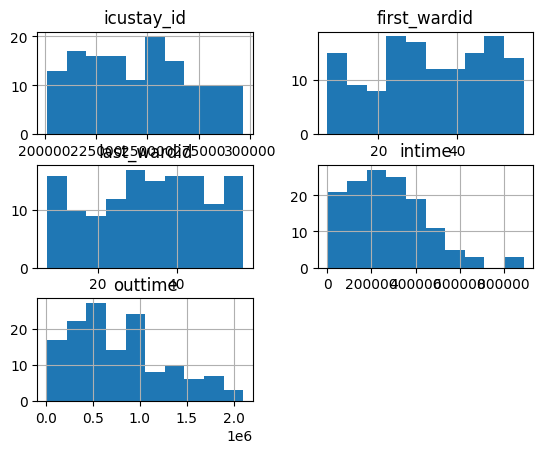

In [46]:
sample.hist()

array([[<Axes: title={'center': 'icustay_id'}>,
        <Axes: title={'center': 'first_wardid'}>],
       [<Axes: title={'center': 'last_wardid'}>,
        <Axes: title={'center': 'intime'}>],
       [<Axes: title={'center': 'outtime'}>, <Axes: >]], dtype=object)

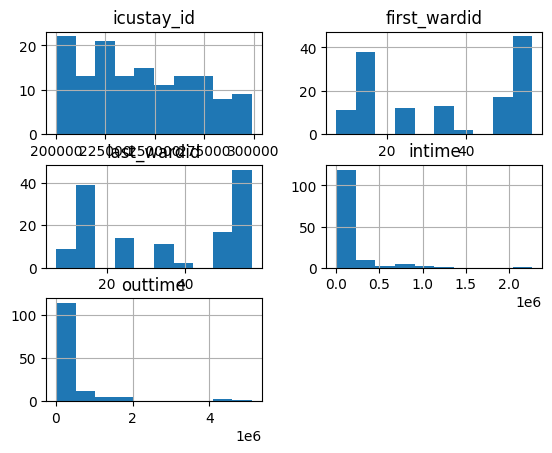

In [47]:
train_data.hist()